## Political ideology analysis

This notebook aims to predict political ideology using the [Augmented IBC Data Set (Iyyer et. al 2014)](https://people.cs.umass.edu/~miyyer/ibc/index.html). The dataset is not included in the GitHub respository; contact Dr. Iyyer for access. I aimed to improve upon the accuracy benchmark in his [2014 paper](https://www.aclweb.org/anthology/P14-1105.pdf). Using the fast.ai text library, I was able to achieve 80.5% accuracy on the original set, an 11.2% improvement. I'm sure further improvements could be achieved using different LM architectures and data augmentation strategies; these are areas for future experimentation.

In [1]:
import treeUtil
import pandas as pd
import pickle
from fastai.text import *
from sklearn.model_selection import train_test_split

In [2]:
path = "(insert dataset path here)"

In [3]:
[lib, con, neutral] = pickle.load(open(path, "rb"))

In [11]:
def label_traverse(n) :
    try : 
        if (n.label != 'Neutral') : 
            print (n.label + ": ")
            if (type(n) is treeUtil.nodeObj) : 
                print(n.get_words())
                print ("\n")
            elif (type(n) is treeUtil.leafObj) :
                print(n.print_leaf())
                print ("\n")
    except (AttributeError):
        # skip if unlabeled
        pass
    if (n.c1 is not None) : label_traverse(n.c1)
    if (n.c2 is not None) : label_traverse(n.c2)

In [12]:
label_traverse(lib[10])

Liberal: 
The additional schooling foisted upon one group by this arbitrary state of affairs produced a scaled-down version of our experiment , allowing Angrist and Krueger to conclude that education did , in fact , help people earn more money .


Liberal: 
produced a scaled-down version of our experiment , allowing Angrist and Krueger to conclude that education did , in fact , help people earn more money


Liberal: 
to conclude that education did , in fact , help people earn more money


Liberal: 
conclude that education did , in fact , help people earn more money




In [110]:
data = pd.DataFrame(columns=['text', 'label'])

In [106]:
def label_add (i, df) :
    try :
        if (i.label != 'Neutral') :
            lab = 1 if i.label == 'Liberal' else 0
            if (type(i) is treeUtil.nodeObj) :
                df.loc[len(df)] = [i.get_words(), lab]
            elif (type(i) is treeUtil.leafObj) :
                df.loc[len(df)] = [i.word, lab]
    except (AttributeError):
        pass
    if (i.c1 is not None) : label_add(i.c1, df)
    if (i.c2 is not None) : label_add(i.c2, df)

In [69]:
def label_list_add (l, df) :
    for i in l :
        label_add(i, df)

In [111]:
label_list_add(lib[:1701], data)
label_list_add(con, data)

In [112]:
data.sample(5)

,text,label
4349,"lower energy use ( though lower yields , too )...",1
9218,ATF whistle-blowers who allege the poorly run ...,0
6148,By asking of border enforcement more than it c...,1
4752,the waste and environmental damage of the low-...,1
5482,some who have fallen for quirky but harmless c...,1


In [113]:
data.sample(10)

,text,label
8148,"started funding radical multiculturalists , ev...",0
2119,"the poor to build wealth , to access the capit...",1
988,free-market ideology,0
10532,its `` mission is to formulate and promote con...,0
11393,"repeal of the estate tax , which affected only...",1
7542,more productive purposes in the free market,0
3973,"could be a backlash of anger , bitterness , an...",1
212,will be critical to the success or failure of ...,1
11161,been an argument for GSEs to guarantee the cre...,0
1139,reducing migratory pressures leading to U.S.-b...,1


In [115]:
data['label'].value_counts()

1    6513
0    5778
Name: label, dtype: int64

In [116]:
[master_train, master_test] = train_test_split(data, train_size = 0.8, stratify=data['label'], shuffle=True)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [117]:
data_lm = TextLMDataBunch.from_df(
    path="./", train_df=master_train, valid_df=master_test, text_cols=0, label_cols=1, max_vocab=80000)

In [118]:
data_lm.show_batch()

idx,text
0,"extraction and climate - related disasters xxbos created a fantastic opportunity for moochers to profit from government - backed loans xxbos the voices and lives of middle - and lower - class working women xxbos xxmaj that is why it is critical for progressives to support an intellectual community in studying the long - term consequences of income inequality , the relationship between equity and growth , and how different"
1,"keep their jobs . xxbos the expansion of the xxmaj american social safety net during the xxmaj great xxmaj depression xxbos reflected among their self - appointed leaders , whose interest lies in simply boosting the number of warm brown bodies they can claim to represent xxbos envision a form of capitalism that would temper our individualism with a `` social market '' -- a phrase the author , perhaps"
2,"the bottom , those who have been written off as apathetic , too ignorant or hopeless , begin to make demands . xxbos been overshadowed by those in the administration , and in key leadership roles in the xxmaj congress , who never seem to miss an opportunity to dismiss environmental protection as a priority xxbos developed anti - laissez - faire arguments and supported xxmaj progressive causes may surprise"
3,"far more if the government had instead improved the incentives for people and businesses to invest , produce and grow , '' presumably through lower taxes and relaxed regulation xxbos argue that three million new xxup u.s. jobs could be created by building wind turbines , making buildings more energy efficient , and designing other kindred projects xxbos the justifications used by foreign forces around women 's rights xxbos xxmaj"
4,"- as well as the old canard that they are hopeless romantics standing athwart the thrust of progress . xxbos the after - tax incomes of the working poor xxbos law , inventors devising new and useful products , entrepreneurs bringing those products to market and finding ever - more - efficient ways to satisfy customers , and individuals producing more than they consume xxbos charge paying patients extra to"


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-02
Min loss divided by 10: 3.02E-02


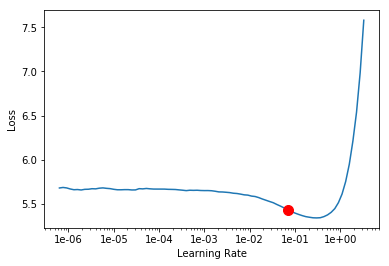

In [119]:
lang = language_model_learner(data_lm, AWD_LSTM)
lang.lr_find()
lang.recorder.plot(suggestion=True)

In [120]:
lang.fit_one_cycle(1, 6.92E-02)

epoch,train_loss,valid_loss,accuracy,time
0,4.901320,4.038635,0.306610,00:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 1.45E-02


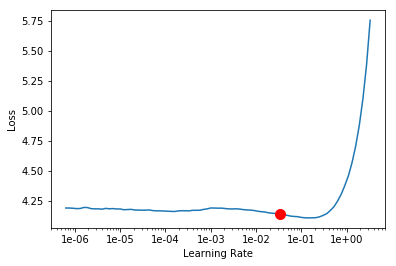

In [121]:
lang.lr_find()
lang.recorder.plot(suggestion=True)

In [122]:
lang.unfreeze()
lang.fit_one_cycle(8, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.824026,3.435923,0.388430,00:09
1,3.409279,2.964176,0.470126,00:09
2,2.966553,2.610362,0.535280,00:09
3,2.530226,2.341542,0.590439,00:09
4,2.096518,2.117270,0.635938,00:09
5,1.727136,1.980465,0.666468,00:09
6,1.446978,1.927016,0.680432,00:09
7,1.292738,1.922629,0.682242,00:09


In [123]:
lang.save("tuned-subsentence-2")
lang.save_encoder('tuned-subsentence-enc-2')

In [124]:
lang.predict("the republicans are always", 20)

'the republicans are always pro - life protections xxbos The strength of the new scholars make it harder to rekindle the automatically available'

In [125]:
data_clas = TextClasDataBunch.from_df(
    path="./", train_df=master_train, valid_df=master_test, text_cols=0, label_cols=1, vocab = data_lm.vocab)

learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_clas.load_encoder('tuned-subsentence-enc-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.45E-02


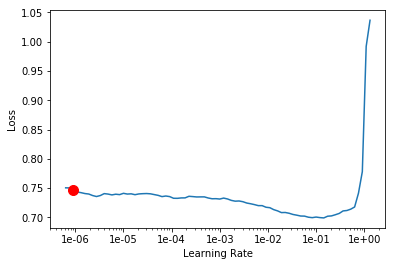

In [126]:
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion=True)

In [127]:
moms = (0.8,0.7)
learn_clas.fit_one_cycle(1, 1e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.653802,0.625575,0.631151,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 9.12E-08


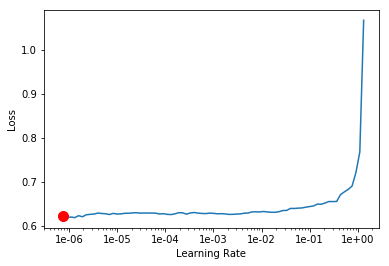

In [128]:
learn_clas.freeze_to(-1)
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion=True)

In [129]:
learn_clas.fit_one_cycle(1, 7.59E-07, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.629883,0.626899,0.629931,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02
Min loss divided by 10: 9.12E-08


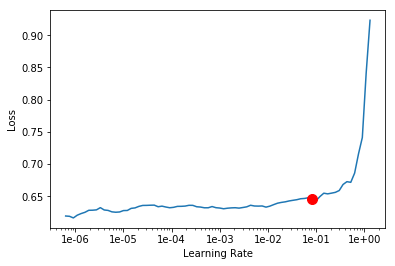

In [130]:
learn_clas.freeze_to(-2)
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion=True)

In [131]:
learn_clas.fit_one_cycle(1, 8.32E-02, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.617729,0.544892,0.718178,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.32E-07


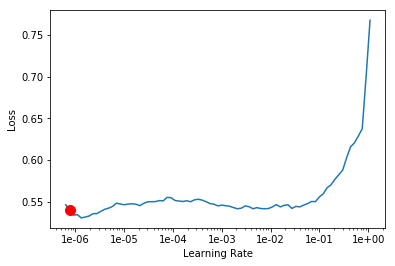

In [132]:
learn_clas.freeze_to(-3)
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion=True)

In [133]:
learn_clas.fit_one_cycle(1, 7.59E-07, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.550386,0.541170,0.716551,00:07


In [134]:
learn_clas.fit_one_cycle(1, 1e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.494467,0.452476,0.774705,00:09


In [135]:
learn_clas.save('frozen-to-3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 5.25E-06


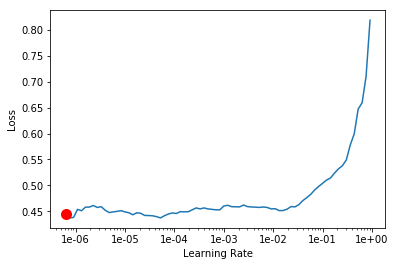

In [136]:
learn_clas.unfreeze()
learn_clas.lr_find()
learn_clas.recorder.plot(suggestion=True)

In [138]:
learn_clas.fit_one_cycle(2, 1e-5, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.446772,0.452418,0.774705,00:09
1,0.458021,0.451154,0.776332,00:11


In [139]:
learn_clas.save('fine-tuned')

In [142]:
import matplotlib.cm as cm

In [151]:
loss, acc = learn_clas.validate()
print(f'Loss: {loss}, Accuracy: {acc*100} %')

Loss: 0.45115354657173157, Accuracy: 77.63318634033203 %


In [173]:
txt_ci = TextClassificationInterpretation.from_learner(learn_clas)
test_text = "this would enable the working poor to move into jobs that may begin by paying a little less but have greater opportunities for wage growth and economic stability down the road ."
txt_ci.show_intrinsic_attention(test_text, cmap=cm.Purples)
learn_clas.predict(test_text)

(Category 1, tensor(1), tensor([0.2486, 0.7514]))

In [188]:
master_test.head()

,text,label
8141,"genuine free trade ( that is , mutually benefi...",0
9605,performed for health reasons are sinful ( this...,0
10247,We have been generally supportive of the effor...,0
9421,"ironic assessment , given that the Change to W...",0
1456,"More troublesome , because it 's more recent t...",1


In [190]:
master_test.sample(10)

,text,label
7579,"were entitled to restitution , including advan...",1
5843,If the intellectual commissars of the oppositi...,1
8967,is unknown as of yet : `` The rates of payment...,0
7427,a lot of creative people,0
2419,"convict terrorist suspects , which leads to th...",1
8887,"Within a very few years , unfunded liabilities...",0
4009,good citizens ( helping that straight man push...,1
10806,"has been visiting India for forty years , doin...",0
1117,many of the practices intended to increase und...,1
2809,ease the impact on workers if the auction of p...,1


In [227]:
afs = pd.DataFrame(columns = ['text', 'label'])

In [228]:
for i in lib : 
    afs.loc[len(afs)] = [i.get_words(), 1]

In [230]:
for i in con :
    afs.loc[len(afs)] = [i.get_words(), 0]

In [231]:
fs_test = pd.DataFrame(columns = ['text', 'label'])

In [233]:
master_test.head()

,text,label
8141,"genuine free trade ( that is , mutually benefi...",0
9605,performed for health reasons are sinful ( this...,0
10247,We have been generally supportive of the effor...,0
9421,"ironic assessment , given that the Change to W...",0
1456,"More troublesome , because it 's more recent t...",1


In [237]:
for i in range(len(master_test)) :
    row = master_test.iloc[i]
    if row['text'] in afs['text'].values :
        fs_test = fs_test.append(row)

In [240]:
len(fs_test)

682

In [241]:
fs_test_db = (TextList.from_df(fs_test, cols='text', vocab=data_lm.vocab)
            .split_none()
            .label_from_df(cols=1)
            .databunch(bs=32))

In [242]:
fs_test_db.show_batch()

text,target
"xxbos xxmaj in an internal study , the xxmaj pentagon 's xxmaj southern xxmaj xxunk , responsible for xxmaj xxunk xxmaj america , xxunk that the rise of state - dominated companies could threaten xxup u.s. access to xxmaj south xxmaj american oil ; xxmaj xxunk , for instance , is xxmaj america 's fourth - biggest oil xxunk , and president xxmaj xxunk xxmaj chavez could damage the xxup",0
"xxbos xxmaj three years ago , xxmaj xxunk xxmaj xxunk published xxmaj murder in xxmaj amsterdam : xxmaj the xxmaj death of xxmaj theo xxmaj van xxmaj gogh and the xxmaj limits of xxmaj tolerance , an analysis of the shocking public slaying by an xxmaj xxunk extremist of a xxmaj dutch filmmaker who , working with xxmaj xxunk xxmaj xxunk xxmaj xxunk , self - declared atheist and xxunk",1
"xxbos xxmaj according to its leaders , as well as its many advocates in the press , xxunk , and the xxmaj united xxmaj nations , xxmaj hezbollah ( in xxmaj xxunk , the xxmaj party of xxmaj god -- sometimes xxunk xxmaj xxunk or xxmaj xxunk ` xxmaj xxunk ) is not a terrorist group at all , but instead a social welfare , charitable organization , providing food",0
"xxbos xxmaj in response , a conservative state senator named xxmaj xxunk xxmaj xxunk xxmaj jr. , who 'd made a name for himself by defending public display of the xxmaj xxunk xxunk and mocking his opponents as the `` xxmaj national xxmaj association of xxmaj xxunk xxmaj people , '' pushed through legislation that made the school board election partisan , thus xxunk a primary process that ensured a",1
"xxbos xxup xxunk : `` xxmaj if nothing else , '' reported the xxmaj christian xxmaj science xxmaj monitor for xxmaj december 27 , 2005 , `` xxmaj washington 's tortured , xxunk budget debate shows that cutting federal spending may be even more difficult today than it used to be ... xxmaj as defense and entitlement spending has grown , most everything else that the xxup us government does",0


In [245]:
loss, acc = learn_clas.validate(dl=fs_test_db.train_dl)
print(f'Loss: {loss}, Accuracy: {acc*100} %')

Loss: 0.5532426238059998, Accuracy: 70.08928680419922 %


In [246]:
learn_clas.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


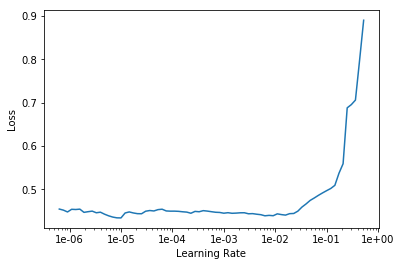

In [247]:
learn_clas.recorder.plot()

In [248]:
learn_clas.fit_one_cycle(2, 1e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.400316,0.365152,0.830419,00:10
1,0.301353,0.338314,0.850752,00:09


In [ ]:
learn_clas.lr_find()
learn_clas.recorder.plot()

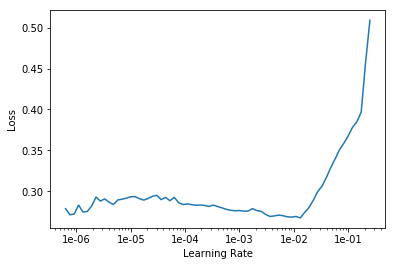

In [250]:
learn_clas.recorder.plot()

In [251]:
learn_clas.fit_one_cycle(2, 4e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.356918,0.343782,0.850346,00:10
1,0.233832,0.300466,0.878813,00:11


In [252]:
learn_clas.save('more-fine-tuned')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


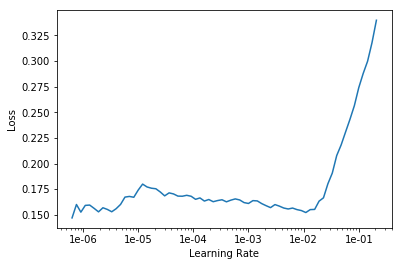

In [253]:
learn_clas.lr_find()
learn_clas.recorder.plot()

In [254]:
learn_clas.fit_one_cycle(2, 3e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.245052,0.315055,0.880033,00:09
1,0.161336,0.319896,0.888573,00:10


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


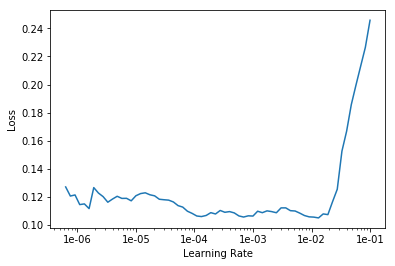

In [255]:
learn_clas.save('more-fine-tuned-2')
learn_clas.lr_find()
learn_clas.recorder.plot()

In [256]:
learn_clas.fit_one_cycle(2, 6e-3, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.309450,0.327223,0.867426,00:11
1,0.195878,0.302358,0.884506,00:09


In [257]:
learn_clas.load('more-fine-tuned-2')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (9832 items)
x: TextList
xxbos caused the xxmaj united xxmaj states to send trillions of dollars to overseas oil producers and have jeopardized our national security by making us dangerously dependent on foreign energy sources,xxbos reducing the xxmaj north 's overconsumption , respecting indigenous and forest peoples ' rights and , notably , reparations for the ecological and climate debts owed by the richest countries to those who are most affected by resource extraction and climate - related disasters,xxbos created a fantastic opportunity for moochers to profit from government - backed loans,xxbos the voices and lives of middle - and lower - class working women,xxbos xxmaj that is why it is critical for progressives to support an intellectual community in studying the long - term consequences of income inequality , the relationship between equity and growth , and how different kinds of public investments affect the labor market .


In [258]:
loss, acc = learn_clas.validate(fs_test_db.train_dl)
print(f'Loss: {loss}, Accuracy: {acc*100} %')

Loss: 0.5078629851341248, Accuracy: 80.5059585571289 %


In [259]:
txt_ci = TextClassificationInterpretation.from_learner(learn_clas)
test_text = "this would enable the working poor to move into jobs that may begin by paying a little less but have greater opportunities for wage growth and economic stability down the road ."
txt_ci.show_intrinsic_attention(test_text, cmap=cm.Purples)
learn_clas.predict(test_text)

(Category 1, tensor(1), tensor([0.1352, 0.8648]))

In [261]:
len(fs_test)

682